In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/Datathon Interbank

/content/drive/My Drive/Datathon Interbank


### Lectura  de datos

In [0]:
import pandas as pd
from sklearn.preprocessing import Imputer
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce

In [0]:
#Leemos los datos
train_bd = pd.read_csv('ib_base_inicial_train.csv', parse_dates=['codmes'], infer_datetime_format=True)
test_bd = pd.read_csv('ib_base_inicial_test.csv', parse_dates=['codmes'], infer_datetime_format=True)
campanias_bd = pd.read_csv('ib_base_campanias.csv', parse_dates=['codmes'], infer_datetime_format=True)
digital_bd = pd.read_csv('ib_base_digital.csv', parse_dates=['codday'], infer_datetime_format=True)
rcc_bd = pd.read_csv('ib_base_rcc.csv', parse_dates=['codmes'], infer_datetime_format=True)
reniec_bd = pd.read_csv('ib_base_reniec.csv')
sunat_bd = pd.read_csv('ib_base_sunat.csv')
vehicular_bd = pd.read_csv('ib_base_vehicular.csv')
sample_sub = pd.read_csv('sampleSubmission.csv')
'''Indicamos parse_dates e infer_datetime_format para que las dechas no sean integer 
ya que originalmente las columnas de fecha están con el formato 201907'''

'Indicamos parse_dates e infer_datetime_format para que las dechas no sean integer \nya que originalmente las columnas de fecha están con el formato 201907'

# Data understanding


### Resumen de los CSVs

In [0]:
#Creamos un dataframe que muestre los shapes de cada csv
lista_csvs = [train_bd, test_bd, campanias_bd, digital_bd, rcc_bd, reniec_bd, sunat_bd, vehicular_bd]
lista_nombres_csvs =  ['train_bd', 'test_bd', 'campanias_bd', 'digital_bd', 'rcc_bd', 
                       'reniec_bd', 'sunat_bd', 'vehicular_bd']
lista_shapes = []
for i in lista_csvs:
  lista_shapes.append(i.shape)
libreriax = {'Nombres': lista_nombres_csvs, 'Shapes': lista_shapes}
tabla_shapes = pd.DataFrame(libreriax)

In [0]:
tabla_shapes

,Nombres,Shapes
0,train_bd,"(212665, 7)"
1,test_bd,"(178685, 6)"
2,campanias_bd,"(4890317, 4)"
3,digital_bd,"(171728, 33)"
4,rcc_bd,"(11705553, 7)"
5,reniec_bd,"(256351, 7)"
6,sunat_bd,"(196336, 3)"
7,vehicular_bd,"(76954, 4)"


###sample_sub


In [0]:
sample_sub.head()

,prediction_id,class
0,1_201906,1
1,4_201906,1
2,4_201905,1
3,6_201906,1
4,7_201905,1


In [0]:
print('shape: {}'.format(sample_sub.shape))
print('prediction_id duplicados: {}'.format(sample_sub.prediction_id.duplicated().sum()))
print('filas duplicadas: {}'.format(sample_sub.duplicated().sum()))

shape: (178685, 2)
prediction_id duplicados: 0
filas duplicadas: 0


### test_bd

"We expect the solution file to have 178685 prediction rows" 
Solo interbank conoce los valores de la fila codtarget de este df, con el cual calculará el margen que deja el modelo. 

predictionid: codigo de cliente_mes en que se le ofreció ofreció tarjeta

In [0]:
test_bd.head()

,codmes,id_persona,cem,ingreso_neto,linea_ofrecida,prediction_id
0,201907,123381,1.0,1340.0,2600,123381_201907
1,201906,125277,1412.0,3166.0,4700,125277_201906
2,201906,9564,389.0,2575.0,5100,9564_201906
3,201906,249494,302.0,1355.0,1300,249494_201906
4,201907,131234,2130.0,10486.0,52400,131234_201907


In [0]:
test_bd.describe()

,id_persona,cem,ingreso_neto,linea_ofrecida
count,178685.000000,178685.000000,178685.000000,178685.000000
mean,131351.092655,873.700870,3161.657151,8475.244704
std,73934.985401,1065.917666,2475.833304,11288.907454
min,1.000000,0.000000,750.000000,700.000000
25%,67469.000000,331.000000,1892.000000,1600.000000
50%,133050.000000,651.000000,2662.000000,4200.000000
75%,195907.000000,1068.000000,3585.000000,10600.000000
max,256375.000000,76716.000000,131309.000000,100000.000000


In [0]:
print('shape: {}'.format(test_bd.shape))
print('id_persona duplicados: {}'.format(test_bd.id_persona.duplicated().sum()))
print('prediction_id duplicados: {}'.format(test_bd.prediction_id.duplicated().sum()))
print('filas duplicadas: {}'.format(test_bd.duplicated().sum()))

shape: (178685, 6)
id_persona duplicados: 36069
prediction_id duplicados: 0
filas duplicadas: 0


In [0]:
#Filas con id_persona duplicado (ordenado de mayor a menor)
test_bd.loc[test_bd.id_persona.duplicated(keep=False),:].sort_values(by=['id_persona'])

,codmes,id_persona,cem,ingreso_neto,linea_ofrecida,prediction_id
31016,201905,4,62.0,1700.0,1000,4_201905
28165,201906,4,75.0,1717.0,1000,4_201906
110323,201905,9,631.0,1962.0,1900,9_201905
115458,201906,9,2280.0,4253.0,19100,9_201906
65378,201907,17,456.0,1735.0,4300,17_201907
...,...,...,...,...,...,...
28950,201906,256342,512.0,2234.0,8900,256342_201906
37024,201907,256358,1423.0,3166.0,6300,256358_201907
43271,201905,256358,1125.0,3166.0,14200,256358_201905
63351,201905,256365,1138.0,3166.0,4700,256365_201905


In [0]:
test_bd.codmes.value_counts()

201907    61720
201905    58595
201906    58370
Name: codmes, dtype: int64

### train_bd

codtarget es el target que se buscará predecir

In [0]:
train_bd.head()

,codmes,id_persona,codtarget,margen,cem,ingreso_neto,linea_ofrecida
0,201901,165747,0,-5.00,1.0,1781.0,1700
1,201903,100117,0,-5.00,478.0,2106.0,2100
2,201901,65751,1,342.99,687.0,3083.0,4600
3,201901,58047,0,-5.00,182.0,1814.0,3600
4,201901,113221,0,-5.00,582.0,2153.0,4300


In [0]:
train_bd.describe()

,codmes,id_persona,codtarget,margen,cem,ingreso_neto,linea_ofrecida
count,212665.000000,212665.000000,212665.000000,212665.000000,212665.000000,212665.000000,212665.000000
mean,201902.556881,127773.211173,0.145638,7.534526,867.481424,3136.008953,8100.679002
std,1.149051,73075.565353,0.352743,70.209438,1075.129778,2492.327322,10970.943116
min,201901.000000,1.000000,0.000000,-728.990000,0.000000,653.000000,700.000000
25%,201901.000000,63944.000000,0.000000,-5.000000,344.000000,1889.000000,1700.000000
50%,201903.000000,128109.000000,0.000000,-5.000000,650.000000,2662.000000,4200.000000
75%,201904.000000,190473.000000,0.000000,-5.000000,1064.000000,3467.000000,9800.000000
max,201904.000000,256375.000000,1.000000,4687.022200,61709.000000,109531.000000,100000.000000


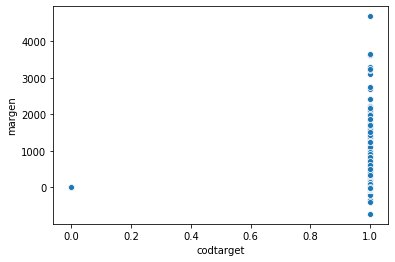

In [0]:
sns.scatterplot(x='codtarget', y="margen", data=train_bd)

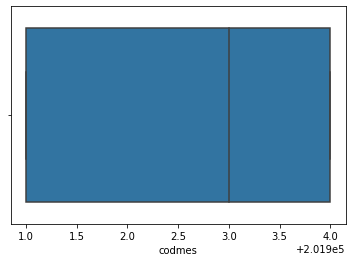

In [0]:
sns.boxplot(x=train_bd['codmes'])

In [0]:
print('shape: {}'.format(train_bd.shape))
print('id_persona duplicados: {}'.format(train_bd.id_persona.duplicated().sum()))
print('filas duplicadas: {}'.format(train_bd.duplicated().sum()))

shape: (212665, 7)
id_persona duplicados: 46811
filas duplicadas: 0


In [0]:
#Personas que obtuvieron una tarjeta pero generaron un margen negativo
train_bd[(train_bd.codtarget == 1) & (train_bd.margen < -5)].sort_values(by='margen')

,codmes,id_persona,codtarget,margen,cem,ingreso_neto,linea_ofrecida
189807,201904,104774,1,-728.99000,4434.0,8664.0,36300
76423,201904,197634,1,-399.51000,818.0,3083.0,13800
66299,201904,85159,1,-349.55000,1.0,1954.0,1000
64394,201903,37288,1,-340.96000,3188.0,7728.0,38600
121758,201901,13318,1,-221.59000,1.0,3257.0,17900
...,...,...,...,...,...,...,...
159164,201902,77669,1,-5.01000,498.0,1787.0,1700
85811,201904,224605,1,-5.01000,794.0,2115.0,4200
100662,201902,212540,1,-5.01000,1377.0,3126.0,7800
86992,201903,124134,1,-5.01000,570.0,1729.0,1000


Hay personas que obtuvieron una tarjeta de crédito pero se espera que tengan un margen negativo. la clave para ganar está en detectar estas personas que no son rentables pero obtendrán una tarjeta

In [0]:
#Personas que no obtuvieron una tarjeta pero generaron un margen positivo
train_bd[(train_bd.codtarget == 0) & (train_bd.margen > 0)].sort_values(by='margen')

,codmes,id_persona,codtarget,margen,cem,ingreso_neto,linea_ofrecida


In [0]:
#Personas que no obtuvieron una tarjeta y no generaron un margen mayor a -5
train_bd[(train_bd.codtarget == 0) & (train_bd.margen < -5)].sort_values(by='margen')

,codmes,id_persona,codtarget,margen,cem,ingreso_neto,linea_ofrecida


### Campanias_bd
Personas que ya estuvieron en campanias. Las personas estuvieron en más de una campania

In [0]:
campanias_bd.head()

,codmes,id_persona,producto,canal_asignado
0,201801,213598,Adelanto de Sueldo,RED DE TIENDAS
1,201801,237325,Adelanto de Sueldo,RED DE TIENDAS
2,201801,82808,Adquisición Convenios,FFVV
3,201801,90555,Adquisición Convenios,FFVV
4,201801,93408,Adquisición Convenios,FFVV


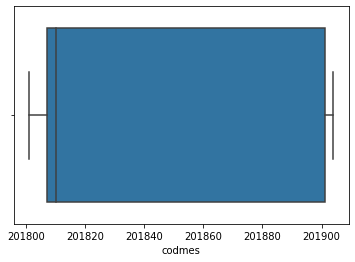

In [0]:
sns.boxplot(x=campanias_bd['codmes'])

In [0]:
print('mes minimo: {}'.format(campanias_bd.codmes.min()))
print('mes máximo: {}'.format(campanias_bd.codmes.max()))

mes minimo: 201801
mes máximo: 201904


In [0]:
print('shape: {}'.format(campanias_bd.shape))
print('id_persona duplicados: {}'.format(campanias_bd.id_persona.duplicated().sum()))
print('filas duplicadas: {}'.format(campanias_bd.duplicated().sum()))

shape: (4890317, 4)
id_persona duplicados: 4650297
filas duplicadas: 0


In [0]:
campanias_bd.id_persona.nunique()

240020

In [0]:
campanias_bd.producto.value_counts()

Adquisición TC                       1446983
Combos                                519145
CD-Ataque                             485166
Préstamos Personales                  442874
Cuenta Sueldo                         326886
Crédito Vehicular                     296455
Cuenta Sueldo Independiente           235601
CTS                                   166649
Combos TC+CUENTA+APP                  137743
Préstamo Express                      131849
Membresia                              82481
Retencion TC                           77674
Cuenta Millonaria                      76703
Adquisición Convenios                  63114
Combos CUENTA+APP                      44392
Combos TC + PA                         33699
ExtraCash                              28832
Crédito Hipotecario                    28062
Pago Automatico                        23146
CD Préstamos                           22658
Depósito a Plazo                       19693
Combos TC+PA                           18393
Retención 

In [0]:
campanias_bd.canal_asignado.value_counts()

RED DE TIENDAS         3185899
TELEVENTAS              881086
FFVV                     87220
BOLSA                    75082
Red de Tiendas           54875
BANCA TELEFONICA         43754
GT                       29948
RED_DE_TIENDAS           27040
BOLSA(EX-E)              21669
CALL EXTERNO             15594
ATM/BPI                   8993
BOLSA(EX)                 7989
TLV CD                    6353
EBP                       5860
EXPRESS                   4478
BOLSA(EX-P)               4456
TLV BD                    3992
GT(EX)                    1620
TLV                       1125
ABP                       1094
TLV SEGMENTOS             1048
EBP_LIMA                  1007
BOLSA(E)                   445
CARTERAS                   203
BOLSA(P)                   171
CARTERA                    139
TLV(EX)                    113
BOLSA(EX-T)                 79
EXPRESS-ABP                 29
EBP LIMA                    24
ER                          13
AC_PROV                      9
CAV     

El dataset de campanias es un distractor, puede resultar en ruido para el modelo. Por ese motivo no se usará para el modelo

### digital_bd
Actividad digital de las personas. Muchas filas duplicadas. Puede haber varios registros por persona en diferentes días

In [0]:
digital_bd.head()

,codday,id_persona,simu_prestamo,benefit,email,facebook,goog,youtb,compb,movil,desktop,n_rep30,recencia,lima_dig,provincia_dig,extranjero_dig,time_ctasimple,time_mllp,time_mllst,time_ctasld,time_tc,n_sesion,busqtc,busqvisa,busqamex,busqmc,busqcsimp,busqmill,busqcsld,busq,n_pag,android,iphone
0,2018-12-04,99258,0.0,0,0,1,0,0,0,1,0,1,1.0,0,1,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,2,8.0,NaN
1,2018-11-02,99258,0.0,0,0,1,0,0,0,1,0,0,100.0,1,0,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,2,8.0,NaN
2,2018-12-03,99258,0.0,0,0,2,0,0,0,2,0,1,8.0,0,1,0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,0,0,0,0,0,4,8.0,NaN
3,2018-11-18,99258,0.0,0,0,1,0,0,0,1,0,1,8.0,1,0,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,8.0,NaN
4,2019-04-02,147297,0.0,0,0,1,0,0,0,1,0,0,100.0,0,1,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,5,8.0,NaN


In [0]:
print('shape: {}'.format(digital_bd.shape))
print('id_persona duplicados: {}'.format(digital_bd.id_persona.duplicated().sum()))
print('filas duplicadas: {}'.format(digital_bd.duplicated().sum()))

shape: (171728, 33)
id_persona duplicados: 148636
filas duplicadas: 111449


In [0]:
digital_bd.nunique()

codday              170
id_persona        23092
simu_prestamo         5
benefit              10
email                 9
facebook              7
goog                 11
youtb                 3
compb                 4
movil                11
desktop              13
n_rep30               2
recencia              5
lima_dig              2
provincia_dig         2
extranjero_dig        2
time_ctasimple      254
time_mllp             1
time_mllst            1
time_ctasld           1
time_tc               1
n_sesion             13
busqtc                2
busqvisa              2
busqamex              1
busqmc                1
busqcsimp             2
busqmill              2
busqcsld              2
busq                  2
n_pag               140
android               6
iphone                5
dtype: int64

In [0]:
digital_bd.dtypes

codday            datetime64[ns]
id_persona                 int64
simu_prestamo            float64
benefit                    int64
email                      int64
facebook                   int64
goog                       int64
youtb                      int64
compb                      int64
movil                      int64
desktop                    int64
n_rep30                    int64
recencia                 float64
lima_dig                   int64
provincia_dig              int64
extranjero_dig             int64
time_ctasimple           float64
time_mllp                float64
time_mllst               float64
time_ctasld              float64
time_tc                  float64
n_sesion                   int64
busqtc                     int64
busqvisa                   int64
busqamex                   int64
busqmc                     int64
busqcsimp                  int64
busqmill                   int64
busqcsld                   int64
busq                       int64
n_pag     

####codday

Después de eliminar filas duplicadas

---



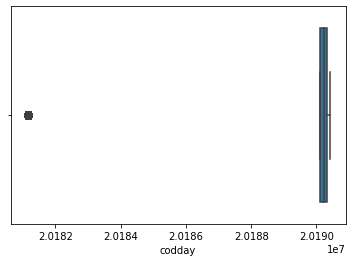

In [0]:
sns.boxplot(x=digital_bd['codday'])

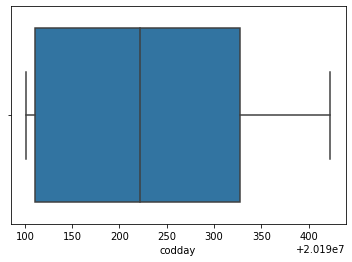

In [0]:
sns.boxplot(x=digital_bd['codday'], showfliers=False)

In [0]:
digital_bd.codday.dtypes

dtype('int64')

In [0]:
print('mes minimo: {}'.format(digital_bd.codday.min()))
print('mes máximo: {}'.format(digital_bd.codday.max()))

mes minimo: 20181101
mes máximo: 20190423


####variables categoricas

In [0]:
#recencia
digital_bd.recencia.value_counts()

100.0    21491
6.0      15034
8.0       8691
1.0       7959
30.0      6561
Name: recencia, dtype: int64

In [0]:
digital_bd.android.value_counts()

8.0    39470
7.0    17104
6.0    13301
5.0     5033
9.0     3557
4.0     1407
Name: android, dtype: int64

In [0]:
digital_bd.iphone.value_counts()

12.0    7267
11.0     819
10.0     272
9.0       28
7.0        2
Name: iphone, dtype: int64

####variables numericas

In [0]:
#tiempos
df = digital_bd.loc[:,'time_ctasimple':'time_tc']
df.describe()

,time_ctasimple,time_mllp,time_mllst,time_ctasld,time_tc
count,171600.000000,171728.0,171728.0,171728.0,171728.0
mean,1.277121,0.0,0.0,0.0,0.0
std,26.212897,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0
25%,0.000000,0.0,0.0,0.0,0.0
50%,0.000000,0.0,0.0,0.0,0.0
75%,0.000000,0.0,0.0,0.0,0.0
max,1953.000000,0.0,0.0,0.0,0.0


Se hará drop a time_mllp,	time_mllst,	time_ctasld, time_tc ya que tienen valores = 0

In [0]:
top_10 = Counter(digital_bd.time_ctasimple).most_common(10)
print(top_10)

[(0.0, 170019), (7.0, 33), (5.0, 27), (3.0, 26), (42.0, 26), (4.0, 26), (16.0, 25), (31.0, 25), (44.0, 24), (92.0, 23)]


In [0]:
#Numeros de veces 1
df = digital_bd.loc[:,'simu_prestamo':'desktop']
df.describe()

,simu_prestamo,benefit,email,facebook,goog,youtb,compb,movil,desktop
count,171581.000000,171728.00000,171728.000000,171728.000000,171728.000000,171728.000000,171728.000000,171728.000000,171728.000000
mean,0.024752,0.02398,0.162589,0.210781,0.415739,0.001322,0.006726,0.641270,0.669640
std,0.166348,0.19630,0.428365,0.470080,0.659004,0.037594,0.086511,0.726407,0.948437
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,4.000000,9.00000,10.000000,6.000000,10.000000,2.000000,3.000000,10.000000,13.000000


In [0]:
#Nro de sesiones en el día
df = digital_bd['n_sesion']
df.describe()

count    171728.000000
mean          1.310334
std           0.773642
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          13.000000
Name: n_sesion, dtype: float64

In [0]:
#Numero de páginas visitadas en el día
df = digital_bd['n_pag']
df.describe()

count    171728.000000
mean          5.412513
std           8.313517
min           0.000000
25%           2.000000
50%           3.000000
75%           6.000000
max         548.000000
Name: n_pag, dtype: float64

In [0]:
digital_bd.loc[:,'n_rep30':'extranjero_dig']

,n_rep30,recencia,lima_dig,provincia_dig,extranjero_dig
0,1,1.0,0,1,0
1,0,100.0,1,0,0
2,1,8.0,0,1,0
3,1,8.0,1,0,0
4,0,100.0,0,1,0
...,...,...,...,...,...
171723,1,8.0,1,0,0
171724,0,100.0,1,0,0
171725,0,30.0,1,0,0
171726,0,100.0,1,0,0


Se hará drop a busqmex y busqmc ya que solo tienen un valor

### rcc_bd
Prestamos de las personas en otros bancos. No hay filas duplicadas. Una persona puede tener más de un prestamo

In [0]:
rcc_bd.head()

,codmes,id_persona,cod_banco,producto,clasif,mto_saldo,rango_mora
0,201811,10155,29,PRESTAMOS COMERCIALES,0.0,36698.4870,1.0
1,201804,75442,29,PRESTAMO PERSONAL,0.0,7971.1182,1.0
2,201902,172772,29,PRESTAMOS COMERCIALES,0.0,821.6077,1.0
3,201810,187572,29,PRESTAMOS COMERCIALES,0.0,9271.8030,1.0
4,201903,255598,29,PRESTAMOS COMERCIALES,0.0,10548.7263,1.0


In [0]:
rcc_bd.id_persona.nunique()

237808

In [0]:
print('shape: {}'.format(rcc_bd.shape))
print('id_persona duplicados: {}'.format(rcc_bd.id_persona.duplicated().sum()))
print('filas duplicadas: {}'.format(rcc_bd.duplicated().sum()))

shape: (11705553, 7)
id_persona duplicados: 11467745
filas duplicadas: 0


####Feature clasif

In [0]:
rcc_bd.clasif.value_counts()

0.0    6699611
1.0     155499
Name: clasif, dtype: int64

La columna clasif se eliminará ya que no aporta valor pues no indica cuáles son las calificaciones de riego

#### Feature codmes

{'boxes': [<matplotlib.lines.Line2D at 0x7f3307d12a20>],
 'caps': [<matplotlib.lines.Line2D at 0x7f3307ca13c8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f3307ca1da0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f3307ca1a58>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f3307d12cf8>,
  <matplotlib.lines.Line2D at 0x7f3307ca1080>]}

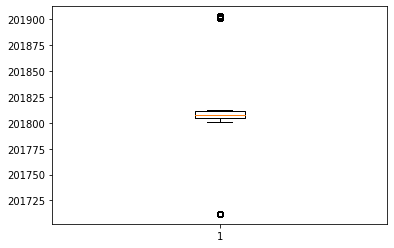

In [0]:
plt.boxplot(rcc_bd.codmes)

In [0]:
print('mes minimo: {}'.format(rcc_bd.codmes.min()))
print('mes máximo: {}'.format(rcc_bd.codmes.max()))

mes minimo: 201712
mes máximo: 201903


#### Feature producto

In [0]:
rcc_bd[rcc_bd.producto == 'LINEA TOTAL TC'].sort_values(by=['mto_saldo'])

,codmes,id_persona,cod_banco,producto,clasif,mto_saldo,rango_mora
8810278,201812,62858,36,LINEA TOTAL TC,NaN,0.0073,NaN
10012171,201811,62858,36,LINEA TOTAL TC,NaN,0.0073,NaN
730436,201811,31227,75,LINEA TOTAL TC,NaN,0.0073,NaN
1524691,201809,31227,75,LINEA TOTAL TC,NaN,0.0073,NaN
9104484,201807,62858,36,LINEA TOTAL TC,NaN,0.0073,NaN
...,...,...,...,...,...,...,...
2400053,201805,28397,7,LINEA TOTAL TC,NaN,466021.1376,NaN
2853606,201807,28397,7,LINEA TOTAL TC,NaN,466029.5837,NaN
856027,201808,28397,7,LINEA TOTAL TC,NaN,469185.6000,NaN
5538798,201809,28397,7,LINEA TOTAL TC,NaN,469755.0000,NaN


In [0]:
#Analizamos los tipos de préstamos que  hay
rcc_bd.producto.value_counts()

LINEA TOTAL TC                           4850443
TARJETAS COMPRAS                         2944579
PRESTAMO PERSONAL                        1638772
TARJETAS EFECTIVO                         790861
PRESTAMOS COMERCIALES                     616894
TARJETAS OTROS CONCEPTOS                  577960
HIPOTECARIO REGULAR                        98239
VEHICULAR                                  74925
HIPOTECARIO MIVIVIENDA                     44387
RESTO RD                                   38059
TARJETA_EMP SIN DEFINIR                    10842
TARJETAS SIN DEFINIR                        6082
CREDITOS CASTIGOS                           2591
TARJETA_EMP EFECTIVO                        2392
SOBREGIRO                                   1951
TARJETA_EMP OTROS CONCEPTOS                 1758
OTROS CREDITOS                              1350
TARJETA_EMP COMPRA                          1016
CARTAS FIANZAS OTORGADAS                     825
REFINANCIADOS                                602
LEASING             

####Feature id_persona

In [0]:
#¿Qué id_personas son las más frecuentes?
top_5 = Counter(rcc_bd.id_persona).most_common(5)
print(top_5)

[(109692, 239), (18704, 236), (84823, 233), (25430, 231), (43713, 227)]


In [0]:
rcc_bd[rcc_bd.id_persona == 109692].codmes.value_counts()

201803    19
201806    18
201805    18
201804    18
201802    18
201901    17
201812    17
201808    17
201807    17
201903    16
201902    16
201811    16
201810    16
201809    16
Name: codmes, dtype: int64

In [0]:
#Todos los créditos de 109692 en 201803 
rcc_bd[(rcc_bd.id_persona == 109692) & (rcc_bd.codmes == 201803)].sort_values(by='cod_banco')

,codmes,id_persona,cod_banco,producto,clasif,mto_saldo,rango_mora
4472700,201803,109692,7,LINEA TOTAL TC,NaN,11778.5500,NaN
1978888,201803,109692,7,TARJETAS COMPRAS,0.0,710.5163,1.0
144273,201803,109692,16,LINEA TOTAL TC,NaN,38389.2400,NaN
8377901,201803,109692,16,TARJETAS COMPRAS,0.0,14161.6934,1.0
7109197,201803,109692,16,PRESTAMO PERSONAL,0.0,22242.9905,1.0
2516328,201803,109692,16,TARJETAS OTROS CONCEPTOS,0.0,5536.9332,1.0
2999570,201803,109692,16,TARJETAS EFECTIVO,0.0,18637.4256,1.0
2017604,201803,109692,16,VEHICULAR,0.0,37144.8090,1.0
2848002,201803,109692,28,LINEA TOTAL TC,NaN,56210.0000,NaN
3124838,201803,109692,28,TARJETAS OTROS CONCEPTOS,0.0,2651.1702,1.0


In [0]:
#Evolución del crédito de TARJETAS COMPRAS de 109692 en el banco 52
rcc_bd[(rcc_bd.id_persona == 109692) & (rcc_bd.cod_banco == 52) & 
                 (rcc_bd.producto == 'TARJETAS COMPRAS')].sort_values(by='codmes') 

,codmes,id_persona,cod_banco,producto,clasif,mto_saldo,rango_mora
1138867,201802,109692,52,TARJETAS COMPRAS,0.0,8969.4443,1.0
2569527,201803,109692,52,TARJETAS COMPRAS,0.0,8274.4843,1.0
1641591,201804,109692,52,TARJETAS COMPRAS,0.0,6161.2657,1.0
1757378,201805,109692,52,TARJETAS COMPRAS,0.0,9229.9083,1.0
374549,201806,109692,52,TARJETAS COMPRAS,0.0,6756.1792,1.0
2076030,201807,109692,52,TARJETAS COMPRAS,0.0,5344.1767,1.0
355736,201808,109692,52,TARJETAS COMPRAS,0.0,2808.6312,1.0
2780559,201809,109692,52,TARJETAS COMPRAS,0.0,2882.9233,1.0
2686654,201810,109692,52,TARJETAS COMPRAS,0.0,2482.7227,1.0
2570694,201811,109692,52,TARJETAS COMPRAS,0.0,1425.2228,1.0


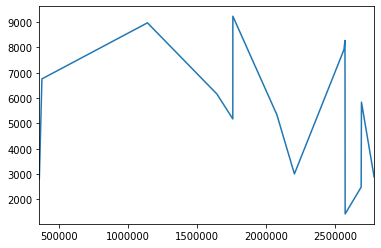

In [0]:
#Evolución del crédito de TARJETAS COMPRAS de 109692 en el banco 52
dframex = rcc_bd[(rcc_bd.id_persona == 109692) & (rcc_bd.cod_banco == 52) & 
                 (rcc_bd.producto == 'TARJETAS COMPRAS')].sort_values(by='codmes') 
dframex.mto_saldo.sort_index().plot()

####Feature rango mora

In [0]:
rcc_bd.rango_mora.value_counts()

1.0    6646227
2.0      85656
3.0      81628
4.0      19523
7.0       9503
5.0       8829
6.0       3744
Name: rango_mora, dtype: int64

### reniec_bd
Variables sociodemograficas de las personas (se desconoce cuáles son). id_perona unicas

In [0]:
reniec_bd.head()

,id_persona,soc_var1,soc_var2,soc_var3,soc_var4,soc_var5,soc_var6
0,219861,0.886792,4,2,6,5,10.0
1,105627,0.641509,4,2,1,2,8.0
2,94514,0.490566,4,2,6,5,10.0
3,55357,0.584906,4,2,6,5,1.0
4,79861,0.603774,4,1,6,5,9.0


In [0]:
reniec_bd.describe()

,id_persona,soc_var1,soc_var2,soc_var3,soc_var4,soc_var5,soc_var6
count,256351.000000,256351.000000,256351.000000,256351.000000,256351.000000,256351.000000,244609.000000
mean,128177.917632,0.637185,3.663103,1.520692,5.361106,4.517478,5.678695
std,74004.748797,0.221286,0.553909,0.499573,1.596789,1.211310,3.128576
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,64088.500000,0.490566,3.000000,1.000000,6.000000,5.000000,3.000000
50%,128177.000000,0.679245,4.000000,2.000000,6.000000,5.000000,5.000000
75%,192264.500000,0.811321,4.000000,2.000000,6.000000,5.000000,8.000000
max,256375.000000,1.000000,4.000000,2.000000,6.000000,5.000000,11.000000


In [0]:
print('shape: {}'.format(reniec_bd.shape))
print('id_persona duplicados: {}'.format(reniec_bd.id_persona.duplicated().sum()))
print('filas duplicadas: {}'.format(reniec_bd.duplicated().sum()))

shape: (256351, 7)
id_persona duplicados: 0
filas duplicadas: 0


### Sunat_bd
Actividad económica de la persona según Sunat. Una persona puede tener más de una actividad registrada en sunat

In [0]:
sunat_bd.head()

,id_persona,activ_econo,meses_alta
0,174454,Grupo_11,70
1,245154,Grupo_15,27
2,1211,Grupo_07,20
3,146154,Grupo_15,135
4,87697,Grupo_07,55


In [0]:
print('shape: {}'.format(sunat_bd.shape))
print('id_persona duplicados: {}'.format(sunat_bd.id_persona.duplicated().sum()))
print('filas duplicadas: {}'.format(sunat_bd.duplicated().sum()))

shape: (196336, 3)
id_persona duplicados: 181
filas duplicadas: 0


In [0]:
top_3 = Counter(sunat_bd['id_persona']).most_common(3)
print(top_3)

[(100310, 3), (92038, 3), (26971, 2)]


### Vehicular_bd
Información sobre los vehiculos de las personas. Dos variables vehiculares que se desconocen. Hay filas idénticas. Una persona puede tener más de un vehículo.

In [0]:
vehicular_bd.head()

,id_persona,marca,veh_var1,veh_var2
0,14908,ACURA,0.942857,3376.0
1,227555,ADVANCE,0.985714,3426.0
2,211938,AKT,1.000000,3426.0
3,20772,ALESIN,0.985714,3424.0
4,75985,ALESIN,0.985714,3424.0


In [0]:
print('shape: {}'.format(vehicular_bd.shape))
print('id_persona duplicados: {}'.format(vehicular_bd.id_persona.duplicated().sum()))
print('filas duplicadas: {}'.format(vehicular_bd.duplicated().sum()))

shape: (76954, 4)
id_persona duplicados: 25566
filas duplicadas: 714


In [0]:
vehicular_bd.marca.nunique()

589

In [0]:
vehicular_bd.marca.unique()

array(['ACURA', 'ADVANCE', 'AKT', 'ALESIN', 'ARGOS', 'ARIES', 'ARO',
       'ARTSUN', "ASESOR MOTOR'S", 'ASIA', 'ASIA MOTORS', 'AUDI',
       'AUSTIN', 'BAIC YINXIANG', 'BAJA', 'BAJAJ', 'BAODIAO', 'BASHAN',
       'BAW', 'BMW', 'BRILLIANCE', 'BUICK', 'BYD', 'CF MOTO', 'CHANGAN',
       'CHANGHE', 'CHENGLONG', 'CHERY', 'CHEVROLET', 'CITROEN', 'CMC',
       'CORENHA', 'CORLUSA', 'CROSS', 'CUSO', 'CYCLER', 'DACIA',
       'DAELIM HONDA', 'DAEWOO', 'DAIHATSU', 'DATSUN', 'DAVEST', 'DFSK',
       'DIM', 'DODGE', 'DONGFENG', 'ESCORTS', 'FAMELAN', 'FAW', 'FCZ',
       'FENIX', 'FIAT', 'FIBRASA', 'FLORES', 'FORD', 'FORLAND', 'FORTTE',
       'FOTON', 'FRUHAUD', 'GEELY', 'GLM', 'GM23', 'GMC', 'GONOW',
       'GREAT DANE', 'GREAT WALL', 'HAFEI', 'HAOJIANG', 'HARLEY DAVIDSON',
       'HARVING', 'HERO', 'HERO MAJESTIC', 'HILLMAN', 'HINO', 'HONDA',
       'HUDSON', 'HUMMER', "HURACAN MOTOR'S", 'HURIOS', 'HYUNDAI',
       'INKA MOTORS', 'INTERNACIONAL', 'INTERNATIONAL', 'INV DAVID',
       'ISUZU', '

el dataset vehicular contiene basura. Hay dato de empresas, scooters (YIBEN), motos (ZONGQING), etc. Se omite dataframe